In [2]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
import json
from PIL import Image
import ipyplot
import random
from scipy.special import softmax
from scipy import stats
from scipy.stats import bernoulli
import random, math
import statsmodels.api as sm
import choix
import networkx as nx
from pathlib import Path
from shutil import copy2
from prettytable import PrettyTable
from PIL import Image
import requests
from io import BytesIO
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

pd.options.display.max_rows = 100
random_state = 42



In [3]:
cnt = 0
for i in  ['Batch_4555956_batch_results.csv',
'Batch_4556853_batch_results.csv',
'Batch_4556855_batch_results.csv',
'Batch_4556856_batch_results.csv',
'Batch_4556858_batch_results.csv',
'Batch_4556860_batch_results.csv',
'Batch_4556861_batch_results.csv',
'Batch_4557421_batch_results.csv',
'Batch_4557423_batch_results.csv',
'Batch_4557425_batch_results.csv',
'Batch_4557427_batch_results.csv',
'Batch_4557430_batch_results.csv',
'Batch_4557431_batch_results.csv',
'Batch_4557432_batch_results.csv',
'Batch_4557433_batch_results.csv',
'Batch_4557835_batch_results.csv',
'Batch_4557836_batch_results.csv',
'Batch_4557837_batch_results.csv',
'Batch_4557838_batch_results.csv',
'Batch_4557839_batch_results.csv',
'Batch_4557840_batch_results.csv',
'Batch_4557841_batch_results.csv',
'Batch_4557842_batch_results.csv',
'Batch_4557843_batch_results.csv']:
    if cnt ==0:
        df = pd.read_csv('data/crowdsourced_annotation_output/'+i)
    else:
        df = pd.concat((df,pd.read_csv('data/crowdsourced_annotation_output/'+i)))
    cnt+=1

In [4]:
len(df)

12000

## Dimensions:
### 24 categories
### 4 outcomes
###  values:
### a) the entire curve (with CI)
### b) median twitter is percentile (with CI)
### c) wins and loses overall, p value

In [5]:
df['Input.foodtype'].unique()

array(['pizza', 'chocolate', 'cheese', 'cake', 'bread', 'salad',
       'chicken', 'pasta or noodles', 'burger', 'soup', 'potato',
       'raclette', 'egg', 'sauce', 'biscuit or cookie', 'croissant',
       'rice', 'ice cream', 'tegetable', 'beef', 'sushi', 'mushroom',
       'tomato', 'curry'], dtype=object)

In [6]:
def process_experiment(gr,cat,outcome):
    res = {}

    res['category'] = cat
    res['outcome'] = outcome


    wins_twitter = len(gr.loc[(gr['Input.image_1']=='T') & \
               (gr[outcome]==1)]) + \
    len(gr.loc[(gr['Input.image_2']=='T') & \
               (gr[outcome]==2)])

    wins_real = len(gr.loc[(gr['Input.image_1']=='R') & \
               (gr[outcome]==1)]) + \
    len(gr.loc[(gr['Input.image_2']=='R') & \
               (gr[outcome]==2)])

    res['wins_twitter'] = wins_twitter/500 
    res['wins_real'] = wins_real/500

    res['wins_p_val'] = stats.binom_test(wins_twitter, n=wins_real+wins_twitter,
                     p=0.5, alternative='two-sided')

    images_competing = pd.Series(sorted(np.unique(list(gr['Input.image_1_url'].unique()) +\
                                                  list(gr['Input.image_2_url'].unique()))))

    data = []
    for cnt,row in gr.iterrows():
        id_1 = (images_competing[images_competing == \
                                row['Input.image_1_url']].index[0])
        id_2 = (images_competing[images_competing == \
                                row['Input.image_2_url']].index[0])

        if row[outcome] == 1:
            data.append((id_1, id_2))
        else:
            data.append((id_2, id_1))

    df_comparisons = pd.DataFrame()
    df_comparisons['image'] = images_competing

    estimations = choix.ilsr_pairwise(len(images_competing),
                                      data, alpha=0.01)

    df_comparisons['estimated'] = estimations

    df_comparisons['rank'] = df_comparisons['estimated'].rank(method = 'average',
         ascending = False)

    x = np.array(range(1,100,1))
    ys= []

    for iteration in range(100):
        quality_real_estimated = df_comparisons.iloc[:50]['estimated'].sample(50, replace = True).values
        quality_twitter_estimated = df_comparisons.iloc[50:]['estimated'].sample(50, replace = True).values

        y_tmp= []
        for percentile in x:
            y_tmp.append(stats.percentileofscore(quality_real_estimated, 
                                          np.percentile(quality_twitter_estimated,percentile), 
                                          kind='rank'))
        ys.append(y_tmp)

    lower_error = []
    upper_error = []
    for p in x:
        lower_error.append(np.percentile(np.percentile(np.array(ys),p, axis = 1), 2.5))
        upper_error.append(np.percentile(np.percentile(np.array(ys),p, axis = 1), 97.5))

    quality_real_estimated = df_comparisons.iloc[:50]['estimated'].values
    quality_twitter_estimated = df_comparisons.iloc[50:]['estimated'].values

    y_estimated = []
    for percentile in x:
        y_estimated.append(stats.percentileofscore(quality_real_estimated, 
                                      np.percentile(quality_twitter_estimated,percentile), 
                                      kind='rank'))

    x = np.array(range(1,100,1))
    ys= []

    for iteration in range(100):

        estimations = choix.ilsr_pairwise(len(images_competing), random.choices(data,k = 500), alpha=0.01)

        df_comparisons['estimated'] = estimations

        quality_real_estimated = df_comparisons.iloc[:50]['estimated'].values
        quality_twitter_estimated = df_comparisons.iloc[50:]['estimated'].values

        y_tmp= []
        for percentile in x:
            y_tmp.append(stats.percentileofscore(quality_real_estimated, 
                                          np.percentile(quality_twitter_estimated,percentile), 
                                          kind='rank'))
        ys.append(y_tmp)

    lower_error = []
    upper_error = []
    bootstrapped_estimate = [] 
    for p in x:
        lower_error.append(np.percentile(np.percentile(np.array(ys),p, axis = 1), 2.5))
        upper_error.append(np.percentile(np.percentile(np.array(ys),p, axis = 1), 97.5))
        bootstrapped_estimate.append(np.percentile(np.percentile(np.array(ys),p, axis = 1),50))

    res['ranks_twitter_lower_error']= lower_error
    res['ranks_twitter_upper_error']= upper_error
    res['ranks_twitter_bootstrapped_estimate']= bootstrapped_estimate
    res['ranks_twitter_y_estimated']= y_estimated


    res['median_twitter_lower_error']= lower_error[49]
    res['median_twitter_upper_error']= upper_error[49]
    res['median_twitter_bootstrapped_estimate']= bootstrapped_estimate[49]
    res['median_twitter_y_estimated']= y_estimated[49]
    
    res['BTs'] = df_comparisons.to_dict()
    
    return res

In [7]:
cols_relevant = ['WorkerId','WorkTimeInSeconds','Input.foodtype','Input.image_1', 'Input.image_2', 'Answer.caloric',
                 'Answer.healthy', 'Answer.homemade', 'Answer.tasty' ,
       'Answer.tag1_1', 'Answer.tag1_2', 'Answer.tag1_3', 'Answer.tag2_1',
       'Answer.tag2_2', 'Answer.tag2_3', 'Input.image_1_url', 'Input.image_2_url']

In [8]:
df = df[cols_relevant]

In [9]:
workers_bad_quality  = ['A3HCWJBU0TWIY3',
 'A1TO20GNODKZ3P',
 'A29JRODY022FFB',
 'A2UYA88EI0VGYE',
 'A336462OADDLRY',
 'A39ZEMJXM4MQUP']

In [10]:
df = df.loc[~df['WorkerId'].isin(workers_bad_quality)]

## Basic statistics

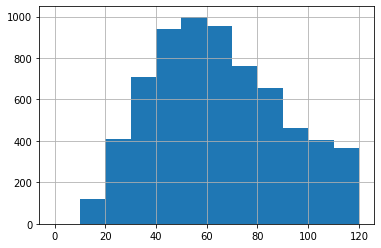

In [11]:
df['WorkTimeInSeconds'].hist(range = [0,120], bins = 12)

In [12]:
60*60*0.15/57

9.473684210526315

In [13]:
df['WorkTimeInSeconds'].mode()

0    57
dtype: int64

In [14]:
def get_winner(x,outcome):
    if ((x['Input.image_1']=='T') and (x[outcome]==1)) or ((x['Input.image_2']=='T') and (x[outcome]==2)):
        return 1
    else:
        return 0

In [15]:
df['twitter_won_tasty'] = df.apply(get_winner, outcome = 'Answer.tasty',axis=1)
df['twitter_won_caloric'] = df.apply(get_winner, outcome = 'Answer.caloric',axis=1)
df['twitter_won_homemade'] = df.apply(get_winner, outcome = 'Answer.homemade',axis=1)
df['twitter_won_healthy'] = df.apply(get_winner, outcome = 'Answer.healthy',axis=1)

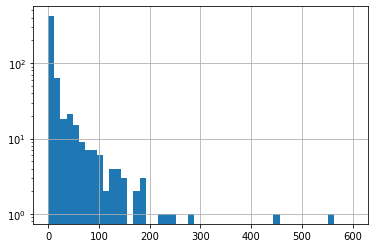

In [16]:
df['WorkerId'].value_counts().hist(range = [0,600], bins = 50)
plt.yscale('log')

In [17]:
workers_few_tasks = list(df['WorkerId'].value_counts().loc[df['WorkerId'].value_counts() <= 10].index)

In [18]:
df_tmp = df.loc[~df['WorkerId'].isin(workers_few_tasks)]

0.6173247521308054
0.4860611587682434


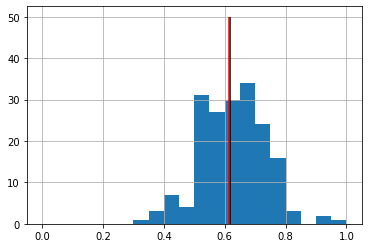

In [19]:
df_tmp.groupby('WorkerId')['twitter_won_tasty'].mean().hist(range = (0,1), bins = 20)
plt.vlines(df['twitter_won_tasty'].mean(), 0,50, color = 'black')
plt.vlines(df_tmp['twitter_won_tasty'].mean(), 0,50, color = 'red')

print(df['twitter_won_tasty'].mean())
print(df['twitter_won_tasty'].std())

0.4596451556792486
0.49839049920317935


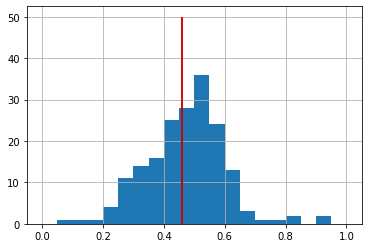

In [20]:
df_tmp.groupby('WorkerId')['twitter_won_healthy'].mean().hist(range = (0,1), bins = 20)
plt.vlines(df['twitter_won_healthy'].mean(), 0,50, color = 'black')
plt.vlines(df_tmp['twitter_won_healthy'].mean(), 0,50, color = 'red')

print(df['twitter_won_healthy'].mean())
print(df['twitter_won_healthy'].std())

0.5846234127674378
0.49280827909628333


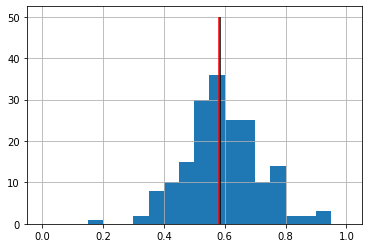

In [21]:
df_tmp.groupby('WorkerId')['twitter_won_caloric'].mean().hist(range = (0,1), bins = 20)
plt.vlines(df['twitter_won_caloric'].mean(), 0,50, color = 'black')
plt.vlines(df_tmp['twitter_won_caloric'].mean(), 0,50, color = 'red')

print(df['twitter_won_caloric'].mean())
print(df['twitter_won_caloric'].std())

0.3808488432770917
0.48561663049252346


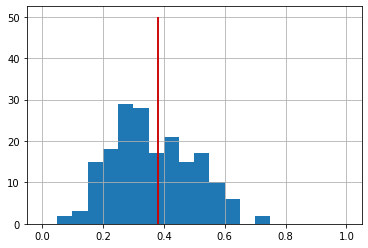

In [22]:
df_tmp.groupby('WorkerId')['twitter_won_homemade'].mean().hist(range = (0,1), bins = 20)
plt.vlines(df['twitter_won_homemade'].mean(), 0,50, color = 'black')
plt.vlines(df_tmp['twitter_won_homemade'].mean(), 0,50, color = 'red')

print(df['twitter_won_homemade'].mean())
print(df['twitter_won_homemade'].std())

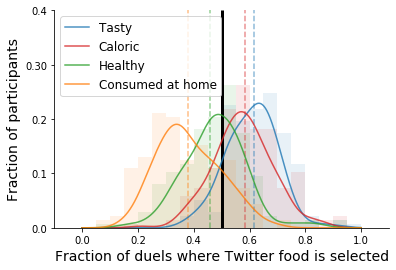

In [24]:
def get_kde(x, X_plot):
    
    kde = KernelDensity(kernel='gaussian', 
                    bandwidth=0.05).fit(x.reshape(-1, 1))
    
    log_dens = kde.score_samples(X_plot)
    return np.exp(log_dens)

X_plot = np.linspace(-0.1, 1.1,
                     1000)[:, np.newaxis]

nbins = 20

n1, bins, patches = plt.hist(df_tmp.groupby('WorkerId')['twitter_won_tasty'].mean(), density = True,range = (0,1), bins = nbins);
n2, bins, patches = plt.hist(df_tmp.groupby('WorkerId')['twitter_won_healthy'].mean(),density = True, range = (0,1), bins = nbins);
n3, bins, patches = plt.hist(df_tmp.groupby('WorkerId')['twitter_won_caloric'].mean(), density = True, range = (0,1), bins = nbins);
n4, bins, patches = plt.hist(df_tmp.groupby('WorkerId')['twitter_won_homemade'].mean(), density = True,range = (0,1), bins = nbins);
plt.close()


ax = plt.subplot(111)
plt.vlines(df['twitter_won_tasty'].mean(), 0,6, color = 'tab:blue', alpha = 0.5, ls = '--')
#plt.plot(np.array(bins[:-1])+(bins[1]/2),np.array(n1)/sum(n1), color = 'tab:blue', label = 'Tasty', alpha = 0.8)
plt.bar(np.array(bins[:-1])+(bins[1]/2),np.array(n1), width = 0.05, color = 'tab:blue',  alpha = 0.1)

plt.plot(np.linspace(0,1,1000)[:, np.newaxis],
         get_kde(df_tmp.groupby('WorkerId')['twitter_won_tasty'].mean().values, X_plot) ,  color = 'tab:blue', label = 'Tasty', alpha = 0.8)


plt.vlines(df['twitter_won_caloric'].mean(), 0,6, color = 'tab:red', alpha = 0.5, ls = '--')
#plt.plot(np.array(bins[:-1])+(bins[1]/2),np.array(n3)/sum(n3), color = 'tab:red', label = 'Caloric', alpha = 0.8)
plt.bar(np.array(bins[:-1])+(bins[1]/2),np.array(n3), width = 0.05, color = 'tab:red',  alpha = 0.1)
plt.plot(np.linspace(0,1,1000)[:, np.newaxis],
         get_kde(df_tmp.groupby('WorkerId')['twitter_won_caloric'].mean().values, X_plot) , color = 'tab:red', label = 'Caloric', alpha = 0.8)



plt.vlines(df['twitter_won_healthy'].mean(), 0,6, color = 'tab:green', alpha = 0.5, ls = '--')
#plt.plot(np.array(bins[:-1])+(bins[1]/2),np.array(n2)/sum(n2), color = 'tab:green', label = 'Healthy', alpha = 0.8)
plt.bar(np.array(bins[:-1])+(bins[1]/2),np.array(n2), width = 0.05, color = 'tab:green',  alpha = 0.1)
plt.plot(np.linspace(0,1,1000)[:, np.newaxis],
         get_kde(df_tmp.groupby('WorkerId')['twitter_won_healthy'].mean().values, X_plot), color = 'tab:green', label = 'Healthy', alpha = 0.8)



plt.vlines(df['twitter_won_homemade'].mean(), 0,6, color = 'tab:orange', alpha = 0.5, ls = '--')
#plt.plot(np.array(bins[:-1])+(bins[1]/2),np.array(n4)/sum(n4), color = 'tab:orange', label = 'Consumed at home', alpha = 0.8)
plt.bar(np.array(bins[:-1])+(bins[1]/2),np.array(n4), width = 0.05, color = 'tab:orange',  alpha = 0.1)
plt.plot(np.linspace(0,1,1000)[:, np.newaxis],
         get_kde(df_tmp.groupby('WorkerId')['twitter_won_homemade'].mean().values, X_plot), color = 'tab:orange', label = 'Consumed at home', alpha = 0.8)



plt.ylabel('Fraction of participants', fontsize= 14)
plt.xlabel('Fraction of duels where Twitter food is selected', fontsize= 14)

plt.vlines(0.5,0, 6, linewidth= 3)

plt.xlim([-0.1,1.1])

plt.ylim([0,6])
plt.legend(fontsize= 12)

ticks = [0,1.5,3,4.5,6]
plt.yticks(ticks,[str(i)[:4] for i in np.array(ticks)/6*0.4])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig('figures/dist_workers.pdf', bbox_inches='tight')

## 1. Make aggregated dataframe

In [23]:
outcomes = ['Answer.tasty','Answer.healthy','Answer.caloric','Answer.homemade']
outcome = outcomes[0]

In [24]:
results = []

for cat,gr in df.groupby('Input.foodtype'):
    print(cat)
    for outcome in outcomes:
        results.append(process_experiment(gr, cat,outcome))

beef
biscuit or cookie
bread
burger
cake
cheese
chicken
chocolate
croissant
curry
egg
ice cream
mushroom
pasta or noodles
pizza
potato
raclette
rice
salad
sauce
soup
sushi
tegetable
tomato


In [25]:
for outcome in outcomes:
    
    res = {}

    res['category'] = 'A_overall'
    res['outcome'] = outcome
    

    wins_twitter = len(df.loc[(df['Input.image_1']=='T') & \
               (df[outcome]==1)]) + \
    len(df.loc[(df['Input.image_2']=='T') & \
               (df[outcome]==2)])
    
    wins_real = len(df.loc[(df['Input.image_1']=='R') & \
               (df[outcome]==1)]) + \
    len(df.loc[(df['Input.image_2']=='R') & \
               (df[outcome]==2)])

    res['wins_twitter'] = (wins_twitter/len(df))
    res['wins_p_val'] = stats.binom_test(wins_twitter, n=wins_real+wins_twitter,
                     p=0.5, alternative='two-sided')
    results.append(res)

In [26]:
df_results = pd.DataFrame(results)

In [27]:
df_results.to_pickle('data/df_results.pickle')

## 2. Make a dataframe per image:
### 2400 images
### 4 BT scores for each image + category
### 9600 rows

In [28]:
list_image_entries = []

for cnt, row in df_results.iterrows():
    if row['category']=='A_overall':
        continue
    for i in range(100):
        entry = {}
        #category
        entry["category"] = row['category']
        #outcome
        entry["outcome"] = row['outcome'].split('.')[1]
        #image
        entry["image"] = row['BTs']['image'][i].split('/')[-1]
        #BT
        entry["BT"] = row['BTs']['estimated'][i]

        list_image_entries.append(entry)


In [29]:
len(list_image_entries)

9600

In [30]:
df_images = pd.DataFrame(list_image_entries)
df_images['id_image'] = df_images.apply(lambda x: x['category'] +", "+ x['image'], axis = 1)

In [31]:
df_images = pd.DataFrame(df_images.pivot(index = 'id_image', columns='outcome').\
             to_records())[["('category', 'caloric')","('image', 'caloric')", "('BT', 'caloric')","('BT', 'healthy')",
                           "('BT', 'homemade')","('BT', 'tasty')"]]

In [32]:
df_images.columns = ["category","image", "BT_caloric","BT_healthy",
                           "BT_homemade","BT_tasty"]

In [33]:
df_images['Twitter'] = df_images['image'].apply(lambda x: 0 if x.split('.')[0].isdigit() else 1)

In [34]:
df_images

,category,image,BT_caloric,BT_healthy,BT_homemade,BT_tasty,Twitter
0,beef,006545.jpg,0.650756,-1.089374,0.320081,1.171520,0
1,beef,006759.jpg,0.350453,0.706168,-0.925039,0.515355,0
2,beef,009481.jpg,0.498086,-0.893741,-0.642459,0.193038,0
3,beef,010907.jpg,0.774665,-0.112834,0.984743,-0.696414,0
4,beef,015360.jpg,-0.052174,0.608811,0.785832,0.099974,0
...,...,...,...,...,...,...,...
2395,tomato,AIVq3u.jpg,1.463886,-0.970635,-0.967351,0.479898,1
2396,tomato,AIWM3B.jpg,-0.571581,0.285118,0.052095,-0.862892,1
2397,tomato,AM3FBP.jpg,-0.306634,0.017652,0.084645,-0.425668,1
2398,tomato,AMRQlJ.jpg,0.331605,0.713727,1.150385,0.661823,1


In [35]:
df_images.to_pickle('data/df_results_images.pickle')

## 3. Make a dataframe for tag analyses

In [25]:
from tqdm.notebook import tqdm

In [38]:
def make_stars(val):
    if val<0.0001:
        return '****'
    elif val<0.001:
        return '***'
    elif val<0.01:
        return '**'
    elif val<0.05:
        return '*'
    else:
        return ''

In [39]:
list_tags = []
for cnt,row in tqdm(df.iterrows()):
    
    if type(row['Answer.tag1_1'])==str:
        entry = {}
        entry['tag'] = row['Answer.tag1_1']
        entry['condition'] = row['Input.image_1']
        entry['category'] = row['Input.foodtype']
        list_tags.append(entry)
    
    if type(row['Answer.tag1_2'])==str:
        entry = {}
        entry['tag'] = row['Answer.tag1_2']
        entry['condition'] = row['Input.image_1']
        entry['category'] = row['Input.foodtype']
        list_tags.append(entry)
    
    if type(row['Answer.tag1_3'])==str:
        entry = {}
        entry['tag'] = row['Answer.tag1_3']
        entry['condition'] = row['Input.image_1']
        entry['category'] = row['Input.foodtype']
        list_tags.append(entry)

    if type(row['Answer.tag2_1'])==str:
        entry = {}
        entry['tag'] = row['Answer.tag2_1']
        entry['condition'] = row['Input.image_2']
        entry['category'] = row['Input.foodtype']
        list_tags.append(entry)
    
    if type(row['Answer.tag2_2'])==str:
        entry = {}
        entry['tag'] = row['Answer.tag2_2']
        entry['condition'] = row['Input.image_2']
        entry['category'] = row['Input.foodtype']
        list_tags.append(entry)
                 
    if type(row['Answer.tag2_3'])==str:
        entry = {}
        entry['tag'] = row['Answer.tag2_3']
        entry['condition'] = row['Input.image_2']
        entry['category'] = row['Input.foodtype']
        list_tags.append(entry)

In [40]:
df_tags = pd.DataFrame(list_tags)

def clean_string(x):
    orig = x
    x = x.lower()
    x = x.strip('.')
    x = x.strip('?')
    x = x.split('to have')[-1] if len(x.split('to have'))>1 else x
    x = x.split('to be')[-1] if len(x.split('to be'))>1 else x
    x = x.split('it has')[-1] if len(x.split('it has'))>1 else x
    x = x.split('looks like')[-1] if len(x.split('looks like'))>1 else x
    x = x.split('have a')[-1] if len(x.split('have a'))>1 else x
    x = x.split('to have')[-1] if len(x.split('to have'))>1 else x
    x = x.split('to use')[-1] if len(x.split('to use'))>1 else x
    x = x.split('has')[-1] if len(x.split('has'))>1 else x
    x = x.split('with')[-1] if len(x.split('with'))>1 else x
    x = x.split('looks')[-1] if len(x.split('looks'))>1 else x
    x = x.split('its')[-1] if len(x.split('its'))>1 else x
    x = x.split('i ')[-1] if len(x.split('i '))>1 else x
    x = x.split('be ')[-1] if len(x.split('be '))>1 else x
    x = x.split('food is ')[-1] if len(x.split('food is '))>1 else x
    x = x.strip(' ')
    x = x.replace(' and ', ', ')
    x = x.replace('home made', 'homemade')
    x = x.replace('home-made', 'homemade')
    x = x.replace('home-style', 'homestyle')
    x = x.replace('mouth watering', 'mouth-watering')
    x = x.replace('mouthwatering', 'mouth-watering')
    x = x.replace('good for health', 'healthy')
    x = x.replace('tasty cheese', 'cheesy, tasty')
    x = x.split(', ')
    return x

In [41]:
df_tags['cleaned'] = df_tags['tag'].apply(clean_string)

In [42]:
df_tags

,tag,condition,category,cleaned
0,healthy,R,pizza,[healthy]
1,uneven ingredients,R,pizza,[uneven ingredients]
2,cheesy,R,pizza,[cheesy]
3,fresh,T,pizza,[fresh]
4,vibrant colors,T,pizza,[vibrant colors]
...,...,...,...,...
58640,SPICY,T,curry,[spicy]
58641,GOOD,T,curry,[good]
58642,GOOD,R,curry,[good]
58643,NICE,R,curry,[nice]


In [43]:
df_tags = df_tags.explode('cleaned')[['cleaned','condition','category']]

In [44]:
twitter = df_tags.loc[df_tags['condition']=='T']
real = df_tags.loc[df_tags['condition']=='R']
tags_tw = list(twitter['cleaned'].value_counts().index)
tags_r = list(real['cleaned'].value_counts().index)
tags = (list(set(tags_tw) & set(tags_r)))
twitter = twitter.loc[twitter['cleaned'].isin(tags)]
real = real.loc[real['cleaned'].isin(tags)]

In [45]:
twitter['cleaned'].value_counts(normalize = True)

tasty                0.049655
healthy              0.032798
delicious            0.030287
fresh                0.021480
yummy                0.020285
                       ...   
pasta casserole      0.000040
covered in cheese    0.000040
yummy taste          0.000040
glass                0.000040
drippy               0.000040
Name: cleaned, Length: 2000, dtype: float64

In [46]:
real['cleaned'].value_counts(normalize = True)

tasty              0.043202
healthy            0.038586
delicious          0.023909
plain              0.020871
yummy              0.016255
                     ...   
served on plate    0.000039
tomotoe            0.000039
unusual looking    0.000039
sashimi            0.000039
snow peas          0.000039
Name: cleaned, Length: 2000, dtype: float64

In [47]:
p = real['cleaned'].value_counts(normalize = True).sort_index()
q = twitter['cleaned'].value_counts(normalize = True).sort_index()


In [48]:
for tag in (p * np.log(p / q)).sort_values(ascending = False)[:30][:9].index: 
    a = twitter['cleaned'].value_counts()[tag]
    b = len(twitter) - twitter['cleaned'].value_counts()[tag]
    
    c = (real['cleaned'].value_counts()[tag])
    d = (len(real) - real['cleaned'].value_counts()[tag])
    
    obs = np.array([[a, b], [c, d]])

    print(tag)
    print(make_stars(stats.chi2_contingency(obs)[1]))
    print('\n')

plain
****


bland
****


simple
****


boring
****


small
****


thin
****


dry
****


healthy
***


homemade
****




In [49]:
(q * np.log(q / p)).sort_values(ascending = False)[:9]

fancy        0.011194
fresh        0.009125
colorful     0.007566
delicious    0.007162
tasty        0.006913
raw          0.006604
gourmet      0.006243
flavorful    0.006061
large        0.005153
Name: cleaned, dtype: float64

In [50]:
for tag in (q * np.log(q / p)).sort_values(ascending = False)[:9].index: 
    a = twitter['cleaned'].value_counts()[tag]
    b = len(twitter) - twitter['cleaned'].value_counts()[tag]
    
    c = (real['cleaned'].value_counts()[tag])
    d = (len(real) - real['cleaned'].value_counts()[tag])
    
    obs = np.array([[a, b], [c, d]])

    print(tag)
    print(make_stars(stats.chi2_contingency(obs)[1]))
    print('\n')

fancy
****


fresh
****


colorful
****


delicious
****


tasty
***


raw
****


gourmet
****


flavorful
****


large
****




## Top 3 words most indicative in each category

In [49]:
for c,gr in df_tags.groupby('category'):
    twitter = gr.loc[gr['condition']=='T']
    real = gr.loc[gr['condition']=='R']
    tags_tw = list(twitter['cleaned'].value_counts().index)
    tags_r = list(real['cleaned'].value_counts().index)
    tags = (list(set(tags_tw) & set(tags_r)))
    twitter = twitter.loc[twitter['cleaned'].isin(tags)]
    real = real.loc[real['cleaned'].isin(tags)]
    p = real['cleaned'].value_counts(normalize = True)
    q = twitter['cleaned'].value_counts(normalize = True)
    print(c)
    print('\n')
    for i in list((p * np.log(p / q)).sort_values(ascending = False)[:3].index):
        print('& '+ i)
    for i in list((q * np.log(q / p)).sort_values(ascending = False)[:3].index):
        print('& '+ i)
    print('\\ \n')

beef


& grilled
& bland
& simple
& raw
& fancy
& flavorful
\ 

biscuit or cookie


& shortbread
& chocolate
& plain
& decorated
& festive
& chocolate chip
\ 

bread


& white
& plain
& dry
& delicious
& fresh
& fancy
\ 

burger


& simple
& small size
& fast food
& interesting
& attractive
& filling
\ 

cake


& small
& chocolate
& chocolatey
& decorated
& fruity
& fancy
\ 

cheese


& boring
& plain
& cold
& melted
& warm
& hot
\ 

chicken


& plain
& bland
& dry
& fried
& tasty
& spicy
\ 

chocolate


& dark
& bitter
& broken
& delicious
& flavoured
& fancy
\ 

croissant


& delicious
& buttery
& stuffed
& warm
& fresh
& healthy
\ 

curry


& rice
& white
& homestyle
& yummy
& healthy
& flavorful
\ 

egg


& plain
& simple
& bland
& decorated
& raw
& colorful
\ 

ice cream


& chocolate
& nice
& simple
& delicious
& decadent
& fancy
\ 

mushroom


& colorful
& simple
& pizza
& raw
& creamy
& large
\ 

pasta or noodles


& plain
& bland
& simple
& fancy
& delicious
& yellow
\ 

pizza

In [54]:
q['fancy']/p['fancy']

4.102171757795694

In [55]:
q['large']/p['large']

3.5527039413382218

In [72]:
for c,gr in df_tags.groupby('category'):
    twitter = gr.loc[gr['condition']=='T']
    real = gr.loc[gr['condition']=='R']
    tags_tw = list(twitter['cleaned'].value_counts().index)
    tags_r = list(real['cleaned'].value_counts().index)
    tags = (list(set(tags_tw) & set(tags_r)))
    twitter = twitter.loc[twitter['cleaned'].isin(tags)]
    real = real.loc[real['cleaned'].isin(tags)]
    p = real['cleaned'].value_counts(normalize = True)
    q = twitter['cleaned'].value_counts(normalize = True)
    
    print(c)
    print('\n')
    
    
    for tag in (p * np.log(p / q)).sort_values(ascending = False)[:3].index: 
        a = twitter['cleaned'].value_counts()[tag]
        b = len(twitter) - twitter['cleaned'].value_counts()[tag]

        c = (real['cleaned'].value_counts()[tag])
        d = (len(real) - real['cleaned'].value_counts()[tag])

        obs = np.array([[a, b], [c, d]])

        print(tag)
        print(stats.chi2_contingency(obs)[1])
        print(make_stars(stats.chi2_contingency(obs)[1]))
        print('\n')

        print('-----------------')
    
    for tag in (q * np.log(q / p)).sort_values(ascending = False)[:3].index: 
        a = twitter['cleaned'].value_counts()[tag]
        b = len(twitter) - twitter['cleaned'].value_counts()[tag]

        c = (real['cleaned'].value_counts()[tag])
        d = (len(real) - real['cleaned'].value_counts()[tag])

        obs = np.array([[a, b], [c, d]])

        print(tag)
        print(make_stars(stats.chi2_contingency(obs)[1]))
        print('\n')


beef


grilled
0.0031989802646295636
**


-----------------
bland
0.008975365943755462
**


-----------------
simple
0.02553998723678753
*


-----------------
raw
***


fancy
*


flavorful



biscuit or cookie


shortbread
0.0012117027497535954
**


-----------------
chocolate
0.010560068774466531
*


-----------------
plain
0.015698058432339308
*


-----------------
decorated
***


festive
**


chocolate chip
**


bread


white
7.10064585640601e-05
****


-----------------
plain
0.0015953604874908967
**


-----------------
dry
0.001921164782888486
**


-----------------
delicious
**


fresh
**


fancy
*


burger


simple
0.0008918476525747158
***


-----------------
small size
0.016382701765483933
*


-----------------
fast food
0.01847585409735165
*


-----------------
interesting
**


attractive
*


filling
*


cake


small
2.6847950941717058e-06
****


-----------------
chocolate
4.1728556253488177e-07
****


-----------------
chocolatey
9.590144574966145e-05
****


---------------